In [31]:
import os
import sys

In [32]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [33]:
sys.path.append("../../deep-learning-dna")

In [34]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import math
import string

import Set_Transformer 
from common.models import dnabert
from common import dna
from lmdbm import Lmdb
from common.data import DnaSequenceGenerator, DnaLabelType, DnaSampleGenerator, find_dbs
import wandb

import tf_utils as tfu

In [35]:
strategy = tfu.devices.select_gpu(0, use_dynamic_memory=True)

---
# Load Data

In [36]:
#Import pretrained model
api = wandb.Api()
model_path = api.artifact("sirdavidludwig/deep-learning-dna/dnabert-pretrain-ablation-dim:8dim").download()
pretrained_model = dnabert.DnaBertModel.load(model_path)
pretrained_model

In [37]:
#Load datafiles
dataset_path = api.artifact("sirdavidludwig/nachusa-dna/dnasamples:v1").download('/data/dna_samples:v1')
samples = find_dbs(dataset_path + '/train')
samples[13]

wandb: Downloading large artifact dnasamples:v1, 4086.55MB. 1260 files... Done. 0:0:0.3


'/data/dna_samples:v1/train/WS-CCW-Jul2015_S82_L001_R1_001.db'

---
# Create Dataset

In [38]:
#Generate batches
split_ratios = [0.8, 0.2]
subsample_length = 400
sequence_length = 150
kmer = 3
batch_size = 20
batches_per_epoch = 20
augument = True
labels = DnaLabelType.SampleIds
seed = 0
rng = np.random.default_rng(seed)
random_samples = samples.copy()

In [40]:
rng.shuffle(random_samples)

In [39]:
trimmed_samples, (train_dataset, val_dataset) = DnaSampleGenerator.split(samples=random_samples[0:5], split_ratios=split_ratios, subsample_length=subsample_length, sequence_length=sequence_length,kmer=kmer,batch_size=batch_size,batches_per_epoch=batches_per_epoch,augment=augument,labels=labels, rng=rng)

In [41]:
random_samples[0:5]

['/data/dna_samples:v1/train/WS-HPW-Apr2016_S45_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-MR-Jul2016_S54_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes54-10-HW_S55_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes2-5-HF_S3_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes19-8-WH_S20_L001_R1_001.db']

In [46]:
max_files = len(train_dataset.samples)
max_files

5

---
# Create Embeddings

In [47]:
#Create 8 dimensional embeddings
pretrained_encoder= dnabert.DnaBertEncoderModel(pretrained_model.base)
pretrained_encoder.trainable = False

In [48]:
class Create_Embeddings(keras.layers.Layer):
    def __init__(self, encoder):
        super(Create_Embeddings, self).__init__()
        self.encoder = encoder
        
    
    def subbatch_predict(self, model, batch, subbatch_size, concat=lambda old, new: tf.concat((old, new), axis=0)):
        def predict(i, result=None):
            n = i + subbatch_size
            pred = tf.stop_gradient(model(batch[i:n]))
            if result is None:
                return [n, pred]
            return [n, concat(result, pred)]
        i, result = predict(0)
        batch_size = tf.shape(batch)[0]
        i, result = tf.while_loop(
            cond=lambda i, _: i < batch_size,
            body=predict,
            loop_vars=[i, result],
            parallel_iterations=1)

        return result
    
    def modify_data_for_input(self, data):
        batch_size = tf.shape(data)[0]
        subsample_size = tf.shape(data)[1]
        flat_data = tf.reshape(data, (batch_size*subsample_size, -1))
        encoded = self.subbatch_predict(self.encoder, flat_data, 128)
        return tf.reshape(encoded, (batch_size, subsample_size, -1))
    
    def call(self, data):
        return  self.modify_data_for_input(data)

---
# Set Transformer Class

In [49]:
class Set_Transformer_Model(keras.Model):
    def __init__(self, num_induce, embed_dim, num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, seq_len, encoder, output_shape):
        super(Set_Transformer_Model, self).__init__()
        
        self.embedding_layer = Create_Embeddings(encoder)
        self.linear_layer = keras.layers.Dense(embed_dim)
        
        self.isabs = []
        
        for i in range(stack):
            self.isabs.append(Set_Transformer.InducedSetAttentionBlock(embed_dim=embed_dim,num_heads=num_heads,num_induce=num_induce,use_layernorm=use_layernorm,pre_layernorm=pre_layernorm,use_keras_mha=use_keras_mha))
      
        self.pooling_layer = Set_Transformer.PoolingByMultiHeadAttention(num_seeds=1,embed_dim=embed_dim,num_heads=1,use_layernorm=use_layernorm,pre_layernorm=pre_layernorm,use_keras_mha=use_keras_mha,is_final_block=True)
    
        self.reshape_layer = keras.layers.Reshape((embed_dim,))
        
        self.output_layer = keras.layers.Dense(output_shape)
    
    def call(self, data):
        
            embeddings = self.embedding_layer(data)
            
            linear_transform = self.linear_layer(embeddings)
            
            attention = linear_transform
            
            for isab in self.isabs:
                attention = isab([attention, None])
                
            pooling = self.pooling_layer(attention)
        
            reshape = self.reshape_layer(pooling)
            
            output = self.output_layer(reshape)    
            
            return output

---
# Create Model

In [50]:
#Hyperparameters
num_induce = 30
embed_dim = 32
num_heads = 4
stack = 4
use_layernorm = True
pre_layernorm = True
use_keras_mha = True
seq_len = 148
encoder = pretrained_encoder
output_shape = max_files

In [51]:
model = Set_Transformer_Model(num_induce, embed_dim, num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, seq_len, encoder, output_shape)
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = [keras.metrics.sparse_categorical_accuracy])

In [52]:
epochs = 300

In [53]:
history = model.fit(x=train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1)

Epoch 1/300
20/20 [==============================] - 83s 4s/step - loss: 1.8873 - sparse_categorical_accuracy: 0.2000 - val_loss: 1.5858 - val_sparse_categorical_accuracy: 0.1750
Epoch 2/300
20/20 [==============================] - 71s 4s/step - loss: 1.5966 - sparse_categorical_accuracy: 0.2025 - val_loss: 1.5192 - val_sparse_categorical_accuracy: 0.1800
Epoch 3/300
20/20 [==============================] - 71s 4s/step - loss: 1.4526 - sparse_categorical_accuracy: 0.4425 - val_loss: 1.4394 - val_sparse_categorical_accuracy: 0.3550
Epoch 4/300
20/20 [==============================] - 71s 4s/step - loss: 1.2915 - sparse_categorical_accuracy: 0.4475 - val_loss: 1.2645 - val_sparse_categorical_accuracy: 0.4150
Epoch 5/300
20/20 [==============================] - 71s 4s/step - loss: 1.1385 - sparse_categorical_accuracy: 0.5275 - val_loss: 1.1444 - val_sparse_categorical_accuracy: 0.4400
Epoch 6/300
20/20 [==============================] - 71s 4s/step - loss: 1.0001 - sparse_categorical_accu

KeyboardInterrupt: 

In [57]:
!pwd

/home/jovyan/work/TransformerXL/STR_XL


In [58]:
model.save_weights("./Saved_Models/Set_Induced.h5")

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = './Models/Set_Dna.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [59]:
model.evaluate(train_dataset[0][0], train_dataset[0][1])

1/1 [==============================] - 2s 2s/step - loss: 0.7937 - sparse_categorical_accuracy: 0.7000


[0.7937148809432983, 0.699999988079071]

In [60]:
model.evaluate(val_dataset[0][0], val_dataset[0][1])

1/1 [==============================] - 2s 2s/step - loss: 0.8181 - sparse_categorical_accuracy: 0.7000


[0.8180536031723022, 0.699999988079071]

In [61]:
tf.argmax(model.predict(train_dataset[0][0], train_dataset[0][1]), -1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [62]:
tf.argmax(model.predict(val_dataset[0][0], val_dataset[0][1]), -1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [63]:
trimmed_samples[0:5]

['/data/dna_samples:v1/train/WS-AG-Apr2016_S85_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-Jul2015_S3_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-Jul2016_S31_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-May2015_S65_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-Oct2016_S72_L001_R1_001.db']

NameError: name 'history' is not defined

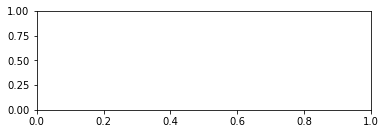

In [65]:
#Plot history and accuracy
plt.subplot(211)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show() 